In [726]:
# Libraries, parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d, interpn, RegularGridInterpolator
from scipy.signal import fftconvolve
from scipy.stats import poisson
from scipy.optimize import minimize
import math

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Conversion factor to go from kpc to 1/eV
conv_factor = 3.086e19 * 5.06773093741 * 1e6

# Conversion factor to go from kpc to m
kpctom = 3.086e19
kpctocm = 3.086e22

# More parameters:
phi0 = 100 # TeV^-1 cm^-2 s^-1, completely random, will be able to calculate this directly I think
e0 = 1 # TeV
index = 2.0 # Completely random, not sure how to calculate this exactly
width = 0.1 # In log10 scale, for cascade-like events, this is being not generous

# del_m2
dm2s = (0, 0, 0)

base = 10

In [3]:
# Download effective area

eff_a = pd.read_csv('EffA_GC_approx.csv').values

In [4]:
"""
Pseudo code steps:

1. Define functions for
    - probability of cascade like event (E, r, del_m2)
    - Effective area (E, theta)
    - Flux (hopefully given) (E, r, theta)
2. Smear over energy (know how to do this [hopefully] already)
3. Smear over angle (I don't know if the ordering of 2 and 3 matters all that much)
    - Actually might be able to do this first, just shove the initial neutrino map into the healpix smoothing fcn
    - Or maybe it would need to be last if we need maps collapsed on distance...
4. Integrate over distance from Earth

"""


"\nPseudo code steps:\n\n1. Define functions for\n    - probability of cascade like event (E, r, del_m2)\n    - Effective area (E, theta)\n    - Flux (hopefully given) (E, r, theta)\n2. Smear over energy (know how to do this [hopefully] already)\n3. Smear over angle (I don't know if the ordering of 2 and 3 matters all that much)\n    - Actually might be able to do this first, just shove the initial neutrino map into the healpix smoothing fcn\n    - Or maybe it would need to be last if we need maps collapsed on distance...\n4. Integrate over distance from Earth\n\n"

In [239]:
# Download the model:

# First index is the particle, second index is the attribute
# Important ones:
# [3]: neutrino particle ID. 12–electron neutrino, 14–muon neutrino, negative numbers are antiparticles
# [4]: neutrino energy [1e-09 EeV]
# [23], [24], [25]: created particle position, X, Y, Z resp. [kpc]

model_0 = np.loadtxt("first_GC_model.txt", comments="#", unpack=False)
model_1 = np.loadtxt("second_GC_model.txt", comments="#", unpack=False)

In [240]:
# Getting the data

num_nu = int(model_1.size/30)
X = np.zeros((num_nu))
Y = np.zeros((num_nu))
Z = np.zeros((num_nu))
E = np.zeros((num_nu))
Ecreate = np.zeros((num_nu))
Esource = np.zeros((num_nu))
for i in range(num_nu):
    X[i] = model_1[i][23]
    Y[i] = model_1[i][24]
    Z[i] = model_1[i][25]
    E[i] = np.log10(model_1[i][4])
    Ecreate[i] = np.log10(model_1[i][22])
    Esource[i] = np.log10(model_1[i][13])



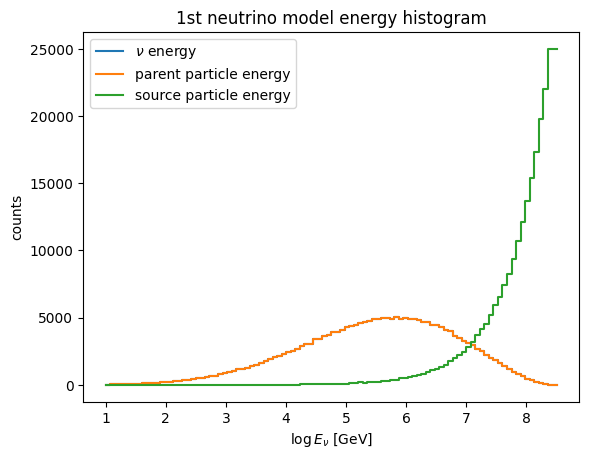

In [241]:
# E in log scale rn
nbins = 100
energies, e_bins = np.histogram(E, nbins)
energies_create, e_bins_create = np.histogram(Ecreate, nbins)
energies_source, e_bins_source = np.histogram(Esource, nbins)
bins_graph = np.delete(e_bins, nbins-1)
fig, ax = plt.subplots()
energy, = ax.step(bins_graph, energies)
energy_create, = ax.step(bins_graph, energies_create)
energy_source, = ax.step(bins_graph, energies_source)
# ax.fill_between(bins_graph, energies, 0, color='blue', alpha=.5, step='pre')
ax.set_xlabel(r"$\log E_{\nu}$ [GeV]")
ax.set_ylabel(r"counts")
ax.set_title("1st neutrino model energy histogram")
ax.legend([energy, energy_create, energy_source], [r"$\nu$ energy", r"parent particle energy", r"source particle energy"])

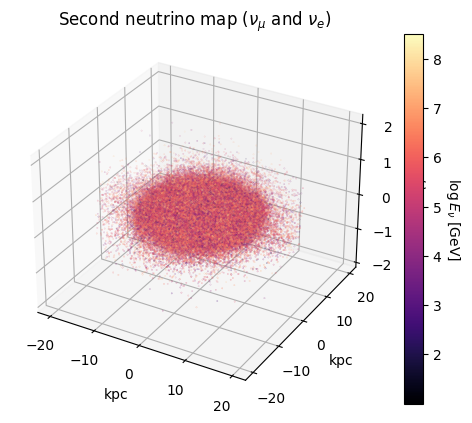

In [7]:
# Printing the data

ax = plt.axes(projection='3d')
# ax.scatter3D(0, 0, 0, s=100)
# ax.scatter3D(8, 0, 0, s=100)
map = ax.scatter3D(X, Y, Z, s=0.02, c=E, cmap='magma')
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_zlabel('kpc')
ax.set_title(r'Second neutrino map ($\nu_{\mu}$ and $\nu_{e}$)')
cbar = plt.colorbar(map)
cbar.set_label(r'$\log E_{\nu}$ [GeV]', rotation=270, labelpad = 15)

In [17]:
# Histogramming in 3D

positions = np.zeros((num_nu, 3))
for nu in range(num_nu):
    positions[nu][0] = model_1[nu][23]
    positions[nu][1] = model_1[nu][24]
    positions[nu][2] = model_1[nu][25]

bin_size=0.3
num_xbins, num_ybins, num_zbins = int(60/bin_size), int(60/bin_size), int(30/bin_size)
H, edges = np.histogramdd(positions, bins=(num_xbins, num_ybins, num_zbins), range=[(-30, 30), (-30, 30), (-3, 3)])

prob_dens_dist = np.divide(H, num_nu*(bin_size**2)*(bin_size/5))

In [9]:
# Printing the histogrammed data

# Printing 3D histogrammed data (looks pretty boring everything's hidden)

x_axes = np.zeros((edges[0].size))
y_axes = np.zeros((edges[1].size))
z_axes = np.zeros((edges[2].size))
# hist_dist = np.zeros((x_axes.size*y_axes.size*z_axes.size, 4))
hist_dist = []
for x in range(x_axes.size-1):
    for y in range(y_axes.size-1):
        for z in range(z_axes.size-1):
            array = [edges[0][x], edges[1][y], edges[2][z], prob_dens_dist[x][y][z]]
            # hist_dist[x+y+z][0] = edges[0][x]
            # hist_dist[x+y+z][1] = edges[1][y]
            # hist_dist[x+y+z][2] = edges[2][z]
            # hist_dist[x+y+z][3] = H[x][y][z]
            hist_dist.append(array)

X = np.zeros(len(hist_dist))
Y = np.zeros(len(hist_dist))
Z = np.zeros(len(hist_dist))
N = np.zeros(len(hist_dist))
for i in range(len(hist_dist)):
    X[i] = hist_dist[i][0]
    Y[i] = hist_dist[i][1]
    Z[i] = hist_dist[i][2]
    N[i] = hist_dist[i][3]

ax = plt.axes(projection='3d')
# ax.scatter3D(0, 0, 0, s=100)
# ax.scatter3D(8, 0, 0, s=100)
map = ax.scatter3D(X, Y, Z, s=1, c=N, cmap='Blues', alpha=0.3)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_zlabel('kpc')
ax.set_title(r'First neutrino map ($\nu_{\mu}$ and $\nu_{e}$)')
cbar = plt.colorbar(map)
cbar.set_label(r'$\log E_{\nu}$ [GeV]', rotation=270, labelpad = 15)

Error in callback <function flush_figures at 0x11db6c860> (for post_execute):


KeyboardInterrupt: 

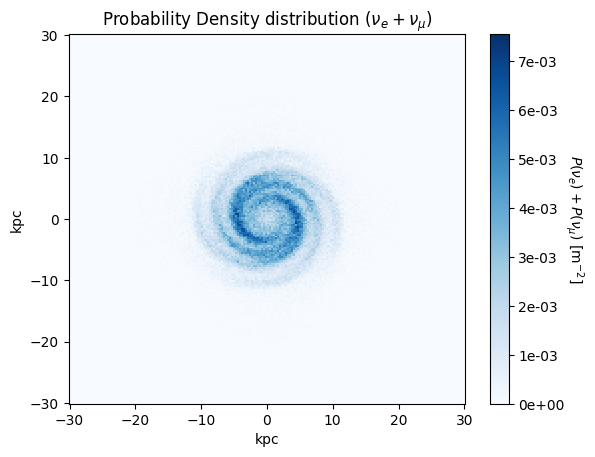

In [10]:
# Histogramming while flattening over z:
bin_size=0.3
num_xbins, num_ybins, num_zbins = int(60/bin_size), int(60/bin_size), int(1)
H, edges = np.histogramdd(positions, bins=(num_xbins, num_ybins, num_zbins), range=[(-30, 30), (-30, 30), (-3, 3)])
prob_dens_dist = np.divide(H, num_nu*(bin_size**2))

X = np.linspace(-30, 30, num_xbins)
Y = np.linspace(-30, 30, num_ybins)
zz = np.zeros((num_xbins, num_ybins))
for x in range(num_xbins):
    for y in range(num_ybins):
        zz[x][y] = prob_dens_dist[x][y][0]

h = plt.pcolormesh(X, Y, zz, shading='auto', cmap='Blues')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(r'Probability Density distribution ($\nu_e + \nu_{\mu})$')
cbar = plt.colorbar(h, anchor=(0.0, 0.5), format='%.0e')
cbar.set_label(r'$P(\nu_e) + P(\nu_{\mu})$ [m$^{-2}$]', rotation=270, labelpad = 15)

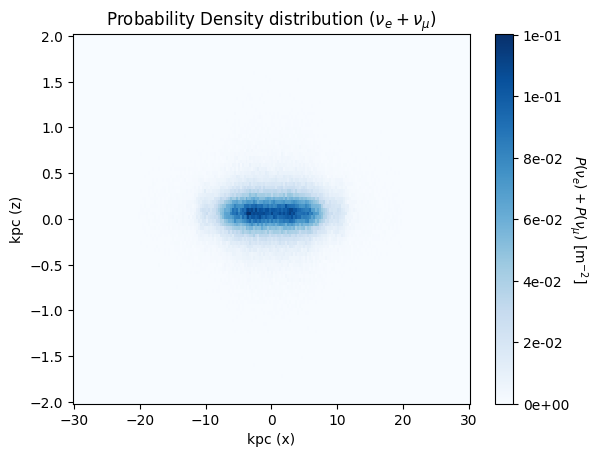

In [11]:
# Histogramming while flattening over y:
bin_size=0.3
num_xbins, num_ybins, num_zbins = int(60/bin_size), int(1), int(30/bin_size)
H, edges = np.histogramdd(positions, bins=(num_xbins, num_ybins, num_zbins), range=[(-30, 30), (-30, 30), (-2, 2)])
prob_dens_dist = np.divide(H, num_nu*(bin_size*(bin_size/5)))

X = np.linspace(-30, 30, num_xbins)
Z = np.linspace(-2, 2, num_zbins)
zz = np.zeros((num_zbins, num_xbins))
for x in range(num_xbins):
    for z in range(num_zbins):
        zz[z][x] = prob_dens_dist[x][0][z]

h = plt.pcolormesh(X, Z, zz, shading='auto', cmap='Blues')
plt.xlabel('kpc (x)')
plt.ylabel('kpc (z)')
plt.title(r'Probability Density distribution ($\nu_e + \nu_{\mu})$')
cbar = plt.colorbar(h, anchor=(0.0, 0.5), format='%.0e')
cbar.set_label(r'$P(\nu_e) + P(\nu_{\mu})$ [m$^{-2}$]', rotation=270, labelpad = 15)

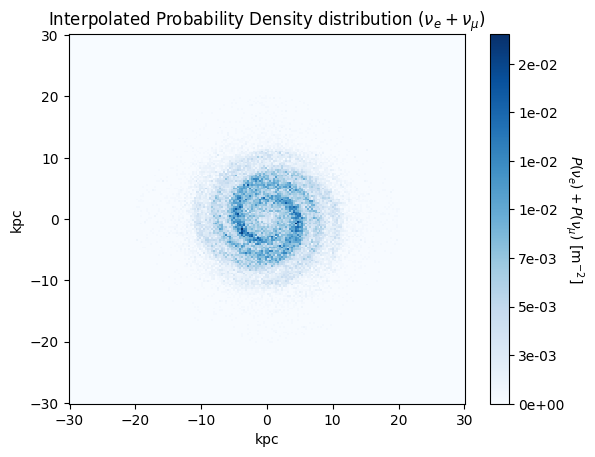

In [810]:
# Printing interpolated function

xbins, ybins = 200, 200
X = np.linspace(-30, 30, xbins)
Y = np.linspace(-30, 30, ybins)
zz = np.zeros((xbins, ybins))
for x in range(xbins):
    for y in range(ybins):
        zz[x][y] = interp([X[x], Y[y], 0])

h = plt.pcolormesh(X, Y, zz, shading='auto', cmap='Blues')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(r'Interpolated Probability Density distribution ($\nu_e + \nu_{\mu})$')
cbar = plt.colorbar(h, anchor=(0.0, 0.5), format='%.0e')
cbar.set_label(r'$P(\nu_e) + P(\nu_{\mu})$ [m$^{-2}$]', rotation=270, labelpad = 15)

In [692]:
# Some core function definitions:

# l_eff per particle, in kpc:

def Leff(x, y, z):
    return np.sqrt((8-x)**2 + y**2 + z**2)

# Oscillation probability: Prob of oscillating into an electron neutrino (still assuming 1:2:0 flavor dist at source)
# Energy in TeV

def OscProb(dm2s, e_true, l_eff):

    l_eff = l_eff*conv_factor

    osc1 = (np.cos((dm2s[0] * l_eff)/(4*e_true*1e12)))**2
    osc2 = (np.cos((dm2s[1] * l_eff)/(4*e_true*1e12)))**2
    osc3 = (np.cos((dm2s[2] * l_eff)/(4*e_true*1e12)))**2

    prob_surv = osc1*(u_e[1]*u_e[1]) + osc2*(u_e[2]*u_e[2]) + osc3*(u_e[3]*u_e[3])
    prob_mue = osc1*(u_e[1]*u_m[1]) + osc2*(u_e[2]*u_m[2]) + osc3*(u_e[3]*u_m[3])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 

    return prob_e


# Effective Area [cm^2]

x, y = [], []
for i in range(len(eff_a)):
    x.append(eff_a[i][0])
    y.append(eff_a[i][1])
f = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
# f = interp1d(x, y)
# f = interp1d(x, y, bounds_error=False, fill_value=0)

def EffA(e_true):
# if (e_true >= eff_a[0][0] and e_true <= eff_a[len(eff_a)-1][0]):
    effa = 10000*f(e_true)
    return effa



# Interpolating the 3D probability density function

x = np.linspace(-30, 30, num_xbins)
y = np.linspace(-30, 30, num_ybins)
z = np.linspace(-3, 3, num_zbins)
interp = RegularGridInterpolator((x, y, z), prob_dens_dist, method='linear', bounds_error=False, fill_value=0)

# Flux function [kpc^-3]:

def Flux(e_true, x, y, z):
    return (interp([x, y, z]))*phi0*(e_true/e0)**(-index)

flux = np.vectorize(Flux, excluded=['x', 'y', 'z'])
vecflux = np.vectorize(Flux)

#Galactic coords to (x, y, z) centered at the galactic center

def Cartesian(r, l, b):
    # r, l, b = coords[0], coords[1], coords[2]
    x = 8 - r*np.cos(l)*np.cos(b)
    y = r*np.sin(l)*np.cos(b)
    z = r*np.sin(b)
    return [x, y, z]

def Cartx(r, l, b):
    x = 8 - r*np.cos(l)*np.cos(b)
    return x 

def Carty(r, l, b):
    y = r*np.sin(l)*np.cos(b)
    return y

def Cartz(r, l, b):
    z = r*np.sin(b)
    return z

cartesian = np.frompyfunc(Cartesian, 3, 1)


In [684]:
rs = np.linspace(0, 8, 10)
ls = np.full(10, np.pi)
bs = np.full(10, 0)

cart = np.column_stack((Cartx(rs, ls, bs), Carty(rs, ls, bs), Cartz(rs, ls, bs)))

cart

array([[8.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.88888889e+00, 1.08857493e-16, 0.00000000e+00],
       [9.77777778e+00, 2.17714987e-16, 0.00000000e+00],
       [1.06666667e+01, 3.26572480e-16, 0.00000000e+00],
       [1.15555556e+01, 4.35429973e-16, 0.00000000e+00],
       [1.24444444e+01, 5.44287466e-16, 0.00000000e+00],
       [1.33333333e+01, 6.53144960e-16, 0.00000000e+00],
       [1.42222222e+01, 7.62002453e-16, 0.00000000e+00],
       [1.51111111e+01, 8.70859946e-16, 0.00000000e+00],
       [1.60000000e+01, 9.79717439e-16, 0.00000000e+00]])

Text(0.5, 1.0, '$\\delta m^2 = 10^{-14.0}$ eV$^2$, $L_{eff} = 4$ kpc')

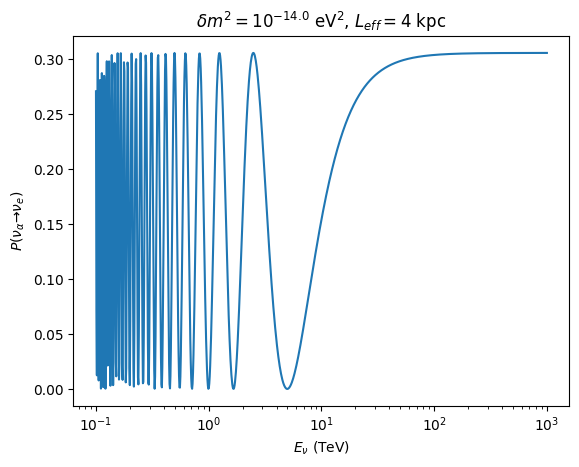

In [763]:
# Plotting oscillation probs:

dm2 = 10**(-13.0)
dm2s = (dm2, dm2, dm2)
length = 2

def OscProb1(e_true):
    return OscProb(dm2s, e_true, length)
oscprob = np.frompyfunc(OscProb1, 1, 1)

a = np.logspace(-1, 3, 1000)
probs = oscprob(a)
# probs = []
# for i in range(len(a)):
#     probs.append(OscProb(dm2s, a[i], length))

fig, ax = plt.subplots()
array = ax.plot(a, probs)
ax.set_xscale('log')
ax.set_xticks([10**(-1), 10**0, 10**1, 10**2, 10**3])
ax.set_xlabel(r"$E_{\nu}$ (TeV)")
ax.set_ylabel(r"$P(\nu_{\alpha} \to \nu_{e})$")
ax.set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$, $L_{eff} = 4$ kpc")


In [772]:
# Plotting "event dists" throughout galaxy

e_true = 3
delm2 = 0
delm2s = (delm2, delm2, delm2)

num_xbins = 100
num_ybins = 100

X = np.linspace(-20, 20, num_xbins)
Y = np.linspace(-20, 20, num_ybins)
zz = np.zeros((num_xbins, num_ybins))
for i, xval in enumerate(X):
    for j, yval in enumerate(Y):
        l_eff = ((yval-8)**2 + xval**2)**0.5
        oscprob = OscProb(delm2s, e_true, l_eff)
        zz[i][j] = Flux(e_true, xval, yval, 0)*oscprob

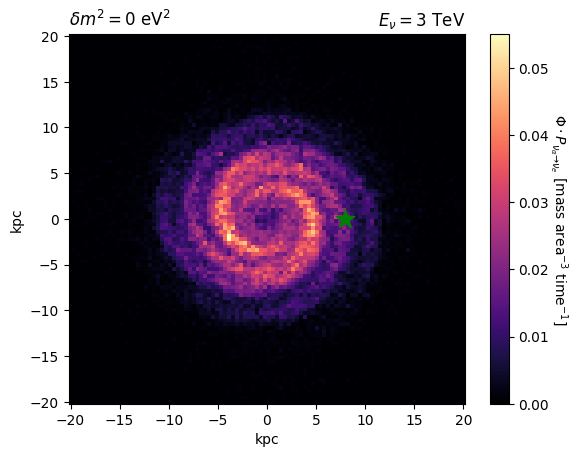

In [776]:
# ctd

h = plt.pcolormesh(X, Y, zz, shading='auto', cmap='magma', vmin=0, vmax=0.055)
plt.scatter(8, 0, s=200, c='Green', marker='*')

plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(r'$\delta m^2 = 0$ eV$^2$', loc='left')
plt.title(r'$E_{\nu} = 3$ TeV', loc='right')
cbar = plt.colorbar(h, anchor=(0.0, 0.1))
#, format='%.0e'
cbar.set_label(r'$\Phi \cdot P_{\nu_{\alpha} \to \nu_{e}}$ [mass area$^{-3}$ time$^{-1}$]', rotation=270, labelpad = 15)

In [778]:
import os
import imageio
from matplotlib import animation

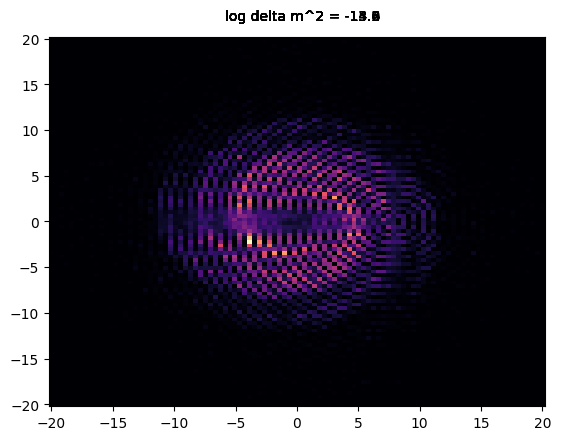

In [802]:
e_true = 1

num_xbins = 100
num_ybins = 100

fig, ax = plt.subplots()

X = np.linspace(-20, 20, num_xbins)
Y = np.linspace(-20, 20, num_ybins)

def Z(delm2):
    delm2s = (delm2, delm2, delm2)
    zz = np.zeros((num_xbins, num_ybins))
    for i, xval in enumerate(X):
        for j, yval in enumerate(Y):
            l_eff = ((yval-8)**2 + xval**2)**0.5
            oscprob = OscProb(delm2s, e_true, l_eff)
            zz[i][j] = Flux(e_true, xval, yval, 0)*oscprob
    return zz

ims = []
for dm2 in [10**(-15.2), 10**(-15), 10**(-14.8), 10**(-14.6), 10**(-14.4), 10**(-14.2), 10**(-14.0), 10**(-13.8), 10**(-13.6), 10**(-13.4), 10**(-13.2), 10**(-13.0)]:
    dm2log = np.log10(dm2)
    im = ax.pcolormesh(X, Y, Z(dm2), cmap='magma', animated=True)
    title = ax.text(0.5, 22, "log delta m^2 = {}".format(dm2log), ha='center')
    ims.append([im, title])




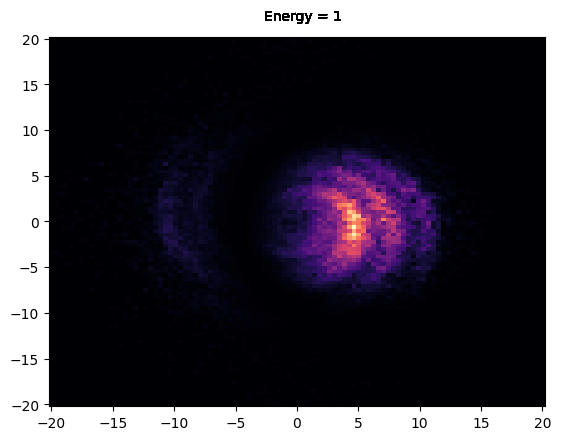

In [805]:
delm2 = 10**(-14.5)

fig, ax = plt.subplots()

def Z(e_true):
    delm2s = (delm2, delm2, delm2)
    zz = np.zeros((num_xbins, num_ybins))
    for i, xval in enumerate(X):
        for j, yval in enumerate(Y):
            l_eff = ((yval-8)**2 + xval**2)**0.5
            oscprob = OscProb(delm2s, e_true, l_eff)
            zz[i][j] = Flux(e_true, xval, yval, 0)*oscprob
    return zz

ims2 = []
for energy in [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]:
    im = ax.pcolormesh(X, Y, Z(e_true), cmap='magma', animated=True)
    title = ax.text(0.5, 22, "Energy = {}".format(e_true), ha='center')
    ims.append([im, title])

In [803]:
ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
ani.save("plots.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


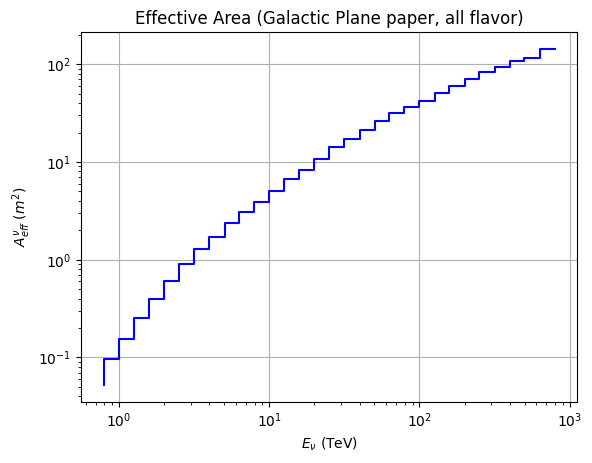

In [48]:
# Plotting Effective Area
x, y = [], []
for i in range(len(eff_a)):
    x.append(eff_a[i][0])
    y.append(eff_a[i][1])

fig, ax = plt.subplots()
plot1 = ax.step(x, y, c='blue')
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$E_{\nu}$ (TeV)")
ax.set_ylabel(r"$A_{eff}^{\nu}$ ($m^2$)")
ax.set_title(r"Effective Area (Galactic Plane paper, all flavor)")
plt.show()

In [274]:
# Perfect detector event distribution function as a fcn of line of sight angle

# LOS length limits in kpc
r0 = 0
r_max = 30
bin_length = 0.5
r_bins = np.arange(0, r_max, bin_length)
numbins = int(r_max/bin_length)

def EventDist(dm2s, e_true, l, b):

    ls, bs = np.full(numbins, l), np.full(numbins, b)

    # want to create two arrays of shape (numbins, 3)
    bins_gal = np.column_stack((r_bins, ls, bs))
    bins_cart = cartesian(r_bins, ls, bs)

    events = np.zeros((numbins))
    for i, element in enumerate(events):
        flux = Flux(e_true, bins_cart[i][0], bins_cart[i][1], bins_cart[i][2])*bin_length
        probe = OscProb(dm2s, e_true, bins_gal[i][0])
        events[i] = flux*probe*EffA(e_true)

    return np.sum(events)


In [741]:
# Creating the full event distribution

# 0.8, 791 TeV 
num_bins = 200
ebins = np.logspace(np.log10(0.9), np.log10(791), num_bins)
def Array(dm2, l, b):
    dm2s = (dm2, dm2, dm2)
    array = np.zeros(num_bins)
    for i in range(num_bins):
        array[i] = EventDist(dm2s, ebins[i], l, b)
    return array


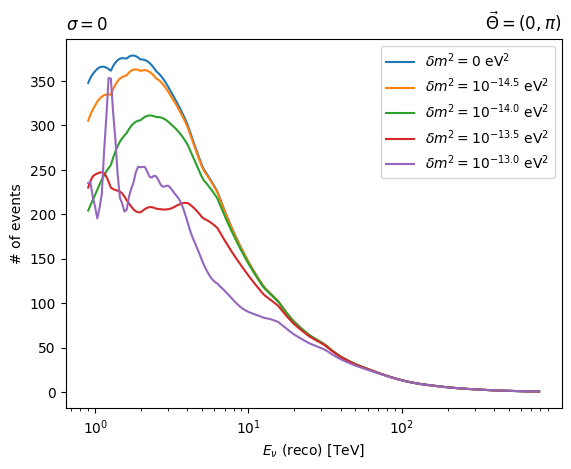

In [742]:
# Plotting a few PD scenarios (perfect detector)

l = 0
b = np.pi
fig, ax = plt.subplots()
null, = ax.plot(ebins, Array(0, l, b))
alt_145, = ax.plot(ebins, Array(10**(-14.5), l, b))
alt_140, = ax.plot(ebins, Array(10**(-14.0), l, b))
alt_135, = ax.plot(ebins, Array(10**(-13.5), l, b))
alt_130, = ax.plot(ebins, Array(10**(-13.0), l, b))
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\sigma = 0$", loc="left")
ax.set_title(r"$\vec{\Theta} = (0, \pi)$", loc='right')
ax.legend([null, alt_145, alt_140, alt_135, alt_130], 
[r"$\delta m^2 = 0$ eV$^2$", r"$\delta m^2 = 10^{-14.5}$ eV$^2$", r"$\delta m^2 = 10^{-14.0}$ eV$^2$", r"$\delta m^2 = 10^{-13.5}$ eV$^2$", r"$\delta m^2 = 10^{-13.0}$ eV$^2$"])

In [221]:
# Different LOS and PD scenarios

l1 = 0
l2 = np.pi/8
l3 = -np.pi/8
l4 = np.pi/4
l5 = -np.pi/4

dm21 = 10**(-13.5)
dm22 = 10**(-14.0)
dm23 = 10**(-14.5)
dm24 = 10**(-15.0)

narray_l1 = Array(0, l1, 0)
aarray_l1_1 = Array(dm21, l1, 0)
aarray_l1_2 = Array(dm22, l1, 0)
aarray_l1_3 = Array(dm23, l1, 0)
aarray_l1_4 = Array(dm24, l1, 0)

narray_l2 = Array(0, l2, 0)
aarray_l2_1 = Array(dm21, l2, 0)
aarray_l2_2 = Array(dm22, l2, 0)
aarray_l2_3 = Array(dm23, l2, 0)
aarray_l2_4 = Array(dm24, l2, 0)

narray_l3 = Array(0, l3, 0)
aarray_l3_1 = Array(dm21, l3, 0)
aarray_l3_2 = Array(dm22, l3, 0)
aarray_l3_3 = Array(dm23, l3, 0)
aarray_l3_4 = Array(dm24, l3, 0)

narray_l4 = Array(0, l4, 0)
aarray_l4_1 = Array(dm21, l4, 0)
aarray_l4_2 = Array(dm22, l4, 0)
aarray_l4_3 = Array(dm23, l4, 0)
aarray_l4_4 = Array(dm24, l4, 0)

narray_l5 = Array(0, l5, 0)
aarray_l5_1 = Array(dm21, l5, 0)
aarray_l5_2 = Array(dm22, l5, 0)
aarray_l5_3 = Array(dm23, l5, 0)
aarray_l5_4 = Array(dm24, l5, 0)



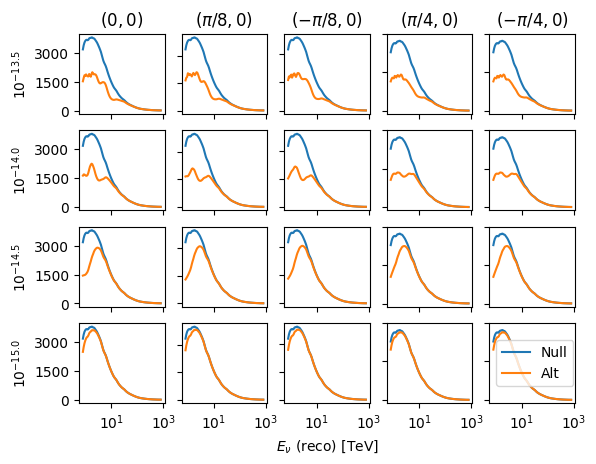

In [225]:
# Plotting these scenarios

fig, axs = plt.subplots(4, 5)

axs[0, 0].plot(ebins, narray_l1)
axs[0, 0].plot(ebins, aarray_l1_1)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yticks([0, 1500, 3000])
# axs[0, 0].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 0].set_ylabel(r"$10^{-13.5}$")
axs[0, 0].set_title(r"$(0, 0)$")

axs[1, 0].plot(ebins, narray_l1)
axs[1, 0].plot(ebins, aarray_l1_2)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yticks([0, 1500, 3000])
axs[1, 0].set_ylabel(r"$10^{-14.0}$")
# axs[1, 0].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 0].set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')

axs[2, 0].plot(ebins, narray_l1)
axs[2, 0].plot(ebins, aarray_l1_3)
axs[2, 0].set_xscale('log')
axs[2, 0].set_yticks([0, 1500, 3000])
axs[2, 0].set_ylabel(r"$10^{-14.5}$")
# axs[2, 0].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 0].set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')

axs[3, 0].plot(ebins, narray_l1)
axs[3, 0].plot(ebins, aarray_l1_4)
axs[3, 0].set_xscale('log')
axs[3, 0].set_yticks([0, 1500, 3000])
axs[3, 0].set_ylabel(r"$10^{-15.0}$")
# axs[3, 0].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 0].set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')



axs[0, 1].plot(ebins, narray_l2)
axs[0, 1].plot(ebins, aarray_l2_1)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yticks([0, 1500, 3000])
# axs[0, 1].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 1].set_title(r"$(\pi/8, 0)$")

axs[1, 1].plot(ebins, narray_l2)
axs[1, 1].plot(ebins, aarray_l2_2)
axs[1, 1].set_xscale('log')
axs[1, 1].set_yticks([0, 1500, 3000])
# axs[1, 1].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 1].set_title(r"$\vec{\Theta} = (\pi/4, 0)$", loc='right')

axs[2, 1].plot(ebins, narray_l2)
axs[2, 1].plot(ebins, aarray_l2_3)
axs[2, 1].set_xscale('log')
axs[2, 1].set_yticks([0, 1500, 3000])
# axs[2, 1].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 1].set_title(r"$\vec{\Theta} = (\pi/4, 0)$", loc='right')

axs[3, 1].plot(ebins, narray_l2)
axs[3, 1].plot(ebins, aarray_l2_4)
axs[3, 1].set_xscale('log')
axs[3, 1].set_yticks([0, 1500, 3000])
# axs[3, 1].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 1].set_title(r"$\vec{\Theta} = (\pi/4, 0)$", loc='right')



axs[0, 2].plot(ebins, narray_l3)
axs[0, 2].plot(ebins, aarray_l3_1)
axs[0, 2].set_xscale('log')
axs[0, 2].set_yticks([0, 1500, 3000])
# axs[0, 2].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 2].set_title(r"$(-\pi/8, 0)$")

axs[1, 2].plot(ebins, narray_l3)
axs[1, 2].plot(ebins, aarray_l3_2)
axs[1, 2].set_xscale('log')
axs[1, 2].set_yticks([0, 1500, 3000])
# axs[1, 2].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 2].set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')

axs[2, 2].plot(ebins, narray_l3)
axs[2, 2].plot(ebins, aarray_l3_3)
axs[2, 2].set_xscale('log')
axs[2, 2].set_yticks([0, 1500, 3000])
# axs[2, 2].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 2].set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')

axs[3, 2].plot(ebins, narray_l3)
axs[3, 2].plot(ebins, aarray_l3_4)
axs[3, 2].set_xscale('log')
axs[3, 2].set_yticks([0, 1500, 3000])
# axs[3, 2].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 2].set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')
axs[3, 2].set_xlabel(r"$E_{\nu}$ (reco) [TeV]")



axs[0, 3].plot(ebins, narray_l4)
axs[0, 3].plot(ebins, aarray_l4_1)
axs[0, 3].set_xscale('log')
axs[0, 3].set_yticks([0, 1500, 3000])
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 3].set_title(r"$(\pi/4, 0)$")
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", rotation=-90, position=(1, 0.5), ha='left', va='center')

axs[1, 3].plot(ebins, narray_l4)
axs[1, 3].plot(ebins, aarray_l4_2)
axs[1, 3].set_xscale('log')
axs[1, 3].set_yticks([0, 1500, 3000])
# axs[1, 3].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

axs[2, 3].plot(ebins, narray_l4)
axs[2, 3].plot(ebins, aarray_l4_3)
axs[2, 3].set_xscale('log')
axs[2, 3].set_yticks([0, 1500, 3000])
# axs[2, 3].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

axs[3, 3].plot(ebins, narray_l4)
axs[3, 3].plot(ebins, aarray_l4_4)
axs[3, 3].set_xscale('log')
axs[3, 3].set_yticks([0, 1500, 3000])
# axs[3, 3].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')



axs[0, 4].plot(ebins, narray_l4)
axs[0, 4].plot(ebins, aarray_l4_1)
axs[0, 4].set_xscale('log')
axs[0, 4].set_yticks([0, 1500, 3000])
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 4].set_title(r"$(-\pi/4, 0)$")
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", rotation=-90, position=(1, 0.5), ha='left', va='center')

axs[1, 4].plot(ebins, narray_l4)
axs[1, 4].plot(ebins, aarray_l4_2)
axs[1, 4].set_xscale('log')
axs[1, 4].set_yticks([0, 1500, 3000])
# axs[1, 3].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

axs[2, 4].plot(ebins, narray_l4)
axs[2, 4].plot(ebins, aarray_l4_3)
axs[2, 4].set_xscale('log')
axs[2, 4].set_yticks([0, 1500, 3000])
# axs[2, 3].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

null, = axs[3, 4].plot(ebins, narray_l4)
alt, = axs[3, 4].plot(ebins, aarray_l4_4)
axs[3, 4].set_xscale('log')
axs[3, 4].set_yticks([0, 1500, 3000])
# axs[3, 3].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')
axs[3, 4].legend([null, alt], [r"Null", r"Alt"])


for ax in axs.flat:
    ax.label_outer()

In [722]:
# Reco energy smearing:

# Limits of integration and bin length size, all in kpc
r0 = 0
r_max = 20
bin_length = 1
r_bins = np.arange(0, r_max, bin_length)
numbins = int(r_max/bin_length)

# Our effective area function is interpolated from sampled points 
# where these are the min and max bins (in TeV):
e_min = 0.7916819159263001
e_max = 791.6819159263017
log_e_min = np.log10(e_min)
log_e_max = np.log10(e_max)


# In log e_reco because our energy resolution is in log e_reco
def SmearedEventDist(dm2s, log_e_reco, l, b):

    ls, bs = np.full(numbins, l), np.full(numbins, b)

    # Two arrays of shape (numbins, 3) that record the galactic and cartesian coordinates respectively
    # of the coordinates we want to evaluate at and sum over
    bins_gal = np.column_stack((r_bins, ls, bs))
    bins_cart = cartesian(r_bins, ls, bs)

    # We smear over our energy resolution by convolving the Gaussian and the rest of the functions in log
    # energy space: we need to do this for each point to be evaluated along our line of sight (hence the index dependence)
    def ConvolveFG(index):

        def F(log_e_reco):
            e_reco = 10**(log_e_reco)
            flux = Flux(e_reco, bins_cart[index][0], bins_cart[index][1], bins_cart[index][2])
            probe = OscProb(dm2s, e_reco, bins_gal[index][0])
            effa = EffA(e_reco)
            return flux*probe*effa

        def G(log_e_reco):
            return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

        
        # Discretize and convolve with scipy.signal.fftconvolve
        num_bins = 10000    
        a = np.linspace(log_e_min, log_e_max, num_bins)

        F_sample = F(a)
        G_sample = G(a)

        H = np.zeros((int(0.932*num_bins)))
        G_sample = np.concatenate((H, G_sample), axis=None)

        convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])

        # Interpolating to get a continuous function again that we can evaluate at any point
        b = np.linspace(log_e_min, log_e_max, len(convolution))
        FG = interp1d(b, convolution) 

        return FG(log_e_reco)   

    
    convolvefg = np.vectorize(ConvolveFG)   

    # Here's our "integration" over r: we sum over points evaluated along the LOS weighted by the bin length
    indices = np.arange(0, numbins, 1)
    events = np.multiply(convolvefg(indices), bin_length)

    return np.sum(events)


In [705]:
# New idea with a differently defined effa function:

# Limits of integration and bin length size, all in kpc
r0 = 0
r_max = 30
bin_length = 0.5
r_bins = np.arange(0, r_max, bin_length)
numbins = int(r_max/bin_length)

# Our effective area function is interpolated from sampled points 
# where these are the min and max bins (in TeV):
e_min = 0.7916819159263001
e_max = 791.6819159263017
log_e_min = np.log10(e_min)
log_e_max = np.log10(e_max)


# In log e_reco because our energy resolution is in log e_reco
def SmearedEventDist1(dm2s, log_e_reco, l, b):

    ls, bs = np.full(numbins, l), np.full(numbins, b)

    # Two arrays of shape (numbins, 3) that record the galactic and cartesian coordinates respectively
    # of the coordinates we want to evaluate at and sum over
    # bins_gal = np.column_stack((r_bins, ls, bs))
    bins_cart = np.column_stack((Cartx(r_bins, ls, bs), Carty(r_bins, ls, bs), Cartz(r_bins, ls, bs)))

    # We smear over our energy resolution by convolving the Gaussian and the rest of the functions in log
    # energy space: F returns an array with numbins elements representing F at each point along the LOS

    def F(log_e_reco):
        e_reco = 10**(log_e_reco)
        flux = vecflux(e_reco, bins_cart[:, 0], bins_cart[:, 1], bins_cart[:, 2])
        probe = OscProb(dm2s, e_reco, r_bins)
        effa = np.full(numbins, EffA(e_reco))
        return np.multiply(flux, probe, effa)
    
    def G(log_e_reco):
        return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

    f = np.vectorize(F, otypes=[np.ndarray])

    # Discretize and convolve with scipy.signal.fftconvolve
    num_bins = 10000    
    a = np.linspace(log_e_min, log_e_max, num_bins)

    F_sample = f(a)     # should return a (num_bins, numbins) shape array
    G_sample = G(a)

    def Convolve(index):

        F_sample_i = F_sample[:, index]
        H = np.zeros((int(984)))
        G_sample = np.concatenate((H, G_sample), axis=None)

        convolution = fftconvolve(F_sample_i, G_sample, mode='same')*(a[1]-a[0])

        # Interpolating to get a continuous function again that we can evaluate at any point
        b = np.linspace(log_e_min, log_e_max, len(convolution))
        FG = interp1d(b, convolution) 
        return FG(log_e_reco)
  

    convolve = np.vectorize(Convolve)   

    # Here's our "integration" over r: we sum over points evaluated along the LOS weighted by the bin length
    indices = np.arange(0, numbins, 1)
    events = np.multiply(convolve(indices), bin_length)

    return np.sum(events)

In [703]:
ls, bs = np.full(numbins, l), np.full(numbins, b)
bins_cart = np.column_stack((Cartx(r_bins, ls, bs), Carty(r_bins, ls, bs), Cartz(r_bins, ls, bs)))
def F(log_e_reco):
    e_reco = 10**(log_e_reco)
    flux = vecflux(e_reco, bins_cart[:, 0], bins_cart[:, 1], bins_cart[:, 2])
    probe = OscProb(dm2s, e_reco, r_bins)
    effa = np.full(numbins, EffA(e_reco))
    return np.multiply(flux, probe, effa)

In [706]:
width = 0.01

dm2 = 0
dm2s = (dm2, dm2, dm2)
# test_0 = EventDist(dm2s, 10, 0, 0)
test_1 = SmearedEventDist1(dm2s, 0, 0, 0)

KeyboardInterrupt: 

In [666]:
# Testing smeared vs. non smeared event dist fcns

width = 0.01

dm2 = 0
dm2s = (dm2, dm2, dm2)
test_0 = EventDist(dm2s, 10, 0, 0)
test_1 = SmearedEventDist(dm2s, np.log10(10), 0, 0)

print(test_0)
print(test_1)

1476.6983448033754
1476.4471986296671


In [269]:
# Testing out the convolution method

r0 = 0
r_max = 30
bin_length = 0.5
r_bins = np.arange(0, r_max, bin_length)
numbins = int(r_max/bin_length)

# in TeV
e_min = 0.7916819159263001
e_max = 791.6819159263017
log_e_min = np.log10(e_min)
log_e_max = np.log10(e_max)

ls, bs = np.full(numbins, l), np.full(numbins, b)

# want to create two arrays of shape (numbins, 3)
bins_gal = np.column_stack((r_bins, ls, bs))
bins_cart = cartesian(r_bins, ls, bs)

i = 10

def F(log_e_reco):
    e_reco = 10**(log_e_reco)
    flux = Flux(e_reco, bins_cart[i][0], bins_cart[i][1], bins_cart[i][2])*bin_length
    probe = OscProb(dm2s, e_reco, bins_gal[i][0])
    return flux*probe*EffA(e_reco)

def G(log_e_reco):
    return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)



# Define the bins
num_bins = 100
a = np.linspace(log_e_min, log_e_max, num_bins)

F_sample = F(a)
G_sample = G(a)

# Discretize F and G
# F_sample = []
# G_sample = []
# for j in range(num_bins):
#     F_sample.append(F(a[j]))
#     G_sample.append(G(a[j]))

# Translation factor to make this fit with the expected results
# H = []
# for i in range(int(num_bins/2)):
#     H.append(0)
# G_sample = H+G_sample

# Convolve
convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])
b = np.linspace(-1, 3, len(convolution))
FG = interp1d(b, convolution)

In [720]:
# Creating the full smeared event distribution:

num_bins = 100
ebins = np.logspace(np.log10(0.9), np.log10(791), num_bins)

def SmearedArray(dm2, l, b):
    dm2s = (dm2, dm2, dm2)
    def SmearedEDist(log_e_reco, l, b):
        return SmearedEventDist(dm2s, log_e_reco, l, b)

    smearededist = np.vectorize(SmearedEDist)
    array = smearededist(np.log10(ebins), l, b)

    return array

Text(0.0, 1.0, '$\\sigma = 0.01$')

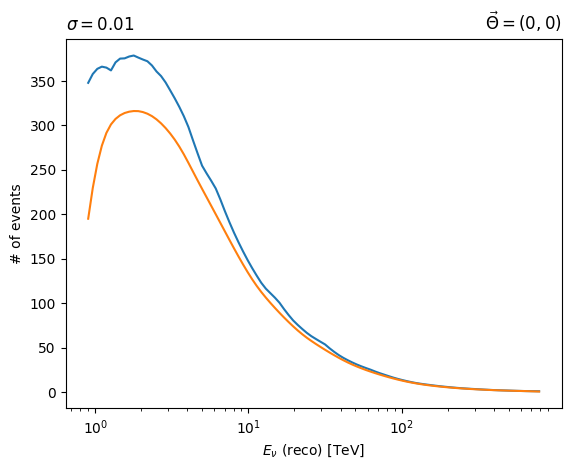

In [764]:
width = 0.1
l = np.pi
b = 0
fig, ax = plt.subplots()
nullperf, = ax.plot(ebins, Array(0, l, b))
nullsmear, = ax.plot(ebins, SmearedArray(0, l, b))
# altperf, = ax.plot(ebins, Array(10**(-14.5), l, b))
# altsmear, = ax.plot(ebins, SmearedArray(10**(-14.5), l, b))
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')
ax.set_title(r"$\sigma = 0.01$", loc='left')
# ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc='center')
# ax.legend([nullperf, nullsmear, altperf, altsmear], [r"Null, no smear", r"Null, smear", r"$10^{-14.5}$, no smear", r"$10^{-14.5}$, smear"])

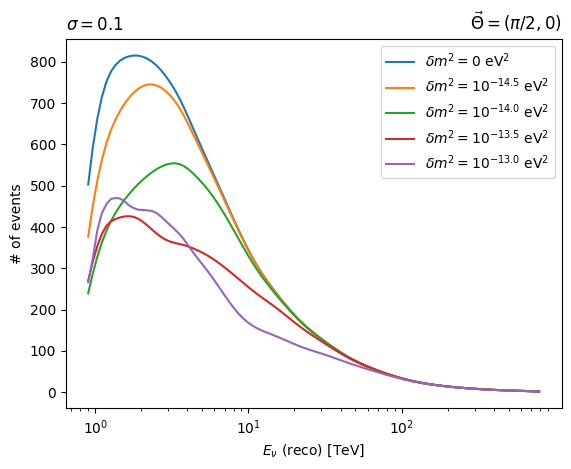

In [765]:

l = np.pi/2
b = 0
fig, ax = plt.subplots()
null, = ax.plot(ebins, SmearedArray(0, l, b))
alt_145, = ax.plot(ebins, SmearedArray(10**(-14.5), l, b))
alt_140, = ax.plot(ebins, SmearedArray(10**(-14.0), l, b))
alt_135, = ax.plot(ebins, SmearedArray(10**(-13.5), l, b))
alt_130, = ax.plot(ebins, SmearedArray(10**(-13.0), l, b))
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\sigma = 0.1$", loc="left")
ax.set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')
ax.legend([null, alt_145, alt_140, alt_135, alt_130], 
[r"$\delta m^2 = 0$ eV$^2$", r"$\delta m^2 = 10^{-14.5}$ eV$^2$", r"$\delta m^2 = 10^{-14.0}$ eV$^2$", r"$\delta m^2 = 10^{-13.5}$ eV$^2$", r"$\delta m^2 = 10^{-13.0}$ eV$^2$"])

In [468]:
# Bin in energy to get some actual binned event distributions (still assuming perfect angular resolution!)

log_e_bins = np.linspace(np.log10(0.9), log_e_max, 50)
e_starts = log_e_bins[:-1]
e_ends = log_e_bins[1:]

def BinnedEventDist(dm2, l, b):

    dm2s = (dm2, dm2, dm2)

    # Need to add a jacobian term so we can do the outside reco energy integration in log e_reco
    def NewIntegrand(log_e_reco):
        return np.log(10)*np.power(10, log_e_reco)*SmearedEventDist(dm2s, log_e_reco, l, b)

    def ERecoIntegral(log_e_start, log_e_end):
        return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

    erecointegral = np.vectorize(ERecoIntegral)

    bins = erecointegral(e_starts, e_ends)

    return bins

In [744]:
# Approximate event distribution function

num_bins = 100
ebins = np.logspace(np.log10(0.9), np.log10(791), num_bins)

def BinnedEventDistApprox(dm2, l, b):

    dm2s = (dm2, dm2, dm2)
    def SmearedEDist(log_e_reco, l, b):
        return SmearedEventDist(dm2s, log_e_reco, l, b)

    smearededist = np.vectorize(SmearedEDist)
    array = smearededist(np.log10(ebins), l, b)

    e_starts = e_bins[:-1]
    e_ends = e_bins[1:]

    bins = np.multiply(array, np.subtract(e_ends, e_starts))

    return bins
    

In [808]:
# Different approximated event dist instances
width = 0.3

l, b = 0, 0
null_dist = BinnedEventDistApprox(0, l, b)
dist_145 = BinnedEventDistApprox(10**(-14.5), l, b)
dist_143 = BinnedEventDistApprox(10**(-14.3), l, b)
dist_140 = BinnedEventDistApprox(10**(-14.0), l, b)

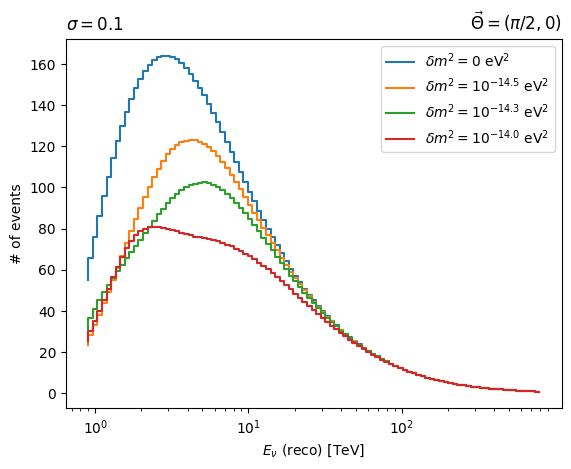

In [809]:
# Plotting approximate event distributions

fig, ax = plt.subplots()
null, = ax.step(ebins, null_dist)
alt_145, = ax.step(ebins, dist_145)
alt_143, = ax.step(ebins, dist_143)
alt_140, = ax.step(ebins, dist_140)
# altperf, = ax.plot(ebins, Array(10**(-14.5), l, b))
# altsmear, = ax.plot(ebins, SmearedArray(10**(-14.5), l, b))
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')
ax.set_title(r"$\sigma = 0.1$", loc='left')
ax.legend([null, alt_145, alt_143, alt_140], 
[r"$\delta m^2 = 0$ eV$^2$", r"$\delta m^2 = 10^{-14.5}$ eV$^2$", r"$\delta m^2 = 10^{-14.3}$ eV$^2$", r"$\delta m^2 = 10^{-14.0}$ eV$^2$"])

In [757]:
l, b = 0, np.pi
null_dist = BinnedEventDistApprox(0, l, b)
dist_135 = BinnedEventDistApprox(10**(-13.5), l, b)
dist_132 = BinnedEventDistApprox(10**(-13.2), l, b)
dist_130 = BinnedEventDistApprox(10**(-13.0), l, b)
dist_128 = BinnedEventDistApprox(10**(-12.8), l, b)

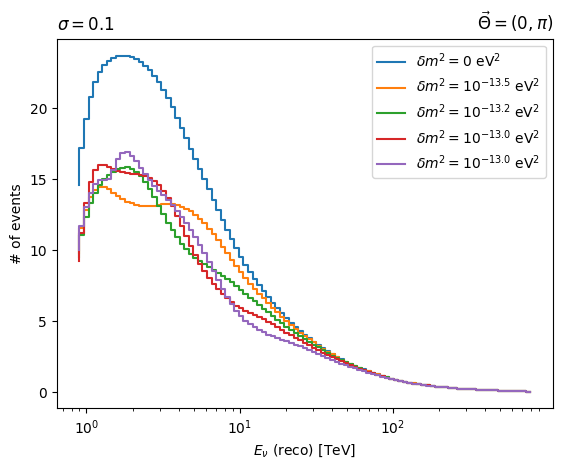

In [758]:
fig, ax = plt.subplots()
null_dist, = ax.step(ebins, null_dist)
alt_135, = ax.step(ebins, dist_135)
alt_132, = ax.step(ebins, dist_132)
alt_130, = ax.step(ebins, dist_130)
alt_128, = ax.step(ebins, dist_128)
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\vec{\Theta} = (0, \pi)$", loc='right')
ax.set_title(r"$\sigma = 0.1$", loc='left')
ax.legend([null, alt_135, alt_132, alt_130, alt_128], 
[r"$\delta m^2 = 0$ eV$^2$", r"$\delta m^2 = 10^{-13.5}$ eV$^2$", r"$\delta m^2 = 10^{-13.2}$ eV$^2$", r"$\delta m^2 = 10^{-13.0}$ eV$^2$", r"$\delta m^2 = 10^{-13.0}$ eV$^2$"])